### RQ2. Simulating Test Prioritization/Selection

In [1]:
import gc
import json
import os
import json
import torch
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
from collections import defaultdict

from matplotlib import colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from adjustText import adjust_text

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.stats import rankdata, pearsonr
from sklearn.metrics import roc_auc_score

from analysis_utils import convert_prob_to_descrete_labels, get_test_results, target_testsuites, prompt_templates

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "grid", "nature"])

cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"], N=11)

task_alias_map = {
    "syntactic_bug_detection": "SYN-BUG",
    "spell_check": "SPELL-CHK",
    "github_typo_check": "GH-TYPO",
    "json_repair": "JSON-FIX",
    "pos_detection": "POS-TAG",
    "topic_classification": "TOPIC-CLS",
    "adding_odd_numbers": "ODD-ADD",
    "model_name_extraction": "MODEL-EX",
}

def calculate_APFDc(scores, observed_correct_probs):
    scores = np.asarray(scores, dtype=float)
    p = np.clip(np.asarray(observed_correct_probs, dtype=float), 0.0, 1.0)
    assert scores.shape == p.shape

    order = np.argsort(scores)
    p_sorted = p[order]

    f = 1.0 - p_sorted

    N = len(f)
    W = f.sum()

    if N == 0:
        return np.nan
    if W <= 0: 
        return 1.0

    positions = np.arange(1, N + 1, dtype=float)

    apfdc = 1.0 - (np.dot(f, positions) / (N * W)) + (1.0 / (2.0 * N))
    return float(apfdc)

In [ ]:
refset_sizes = [100, 200, 300, 400, 500]

target_layer_map = {
    'llama': 21,
    'gemma': 28,
    'mistral': 22
}

target_methods = ['balanced']
NUM_INITIAL_TESTS = 10
NUM_RANDOM_SEEDS = 10

target_iterations = [size // 10 for size in refset_sizes]

def load_individual_run_result(task, target_method, seed, num_reference, target_llm='llama', omit_references=True):
    result_suffix = f"_{target_llm}"
    target_layer = target_layer_map[target_llm]
    
    task_result_df = pd.read_pickle('../experiments/results_GMM/LIH_refset_iter_10{}/{}/layer_{}_seed_{}/{}_pca.pkl'.format(result_suffix, task, target_layer, seed, target_method))
    target_iteration_df = task_result_df[task_result_df['iteration'] == num_reference // 10].copy()
    
    target_indices = sorted(target_iteration_df.input_index.tolist())[:-NUM_INITIAL_TESTS]
    target_iteration_df = target_iteration_df[target_iteration_df['input_index'].isin(target_indices)] # Omit initial tests

    if omit_references:
        return target_iteration_df[target_iteration_df['label'] != 'ref']
    else:
        return target_iteration_df
    
def load_baseline_OOD_run_result(task, seed, num_reference, target_llm='llama', omit_references=True):
    result_suffix = f"_{target_llm}"
    target_layer = target_layer_map[target_llm]
    
    task_result_df = pd.read_pickle(f'../clotho/results{result_suffix}/{task}/precalculated_metrics/LIH_unweighted_SA_refset_layer_{target_layer}_10_0.5.pkl')
    target_iteration_df = task_result_df[(task_result_df['reference_set_size'] == num_reference) & (task_result_df['seed'] == seed)].copy()
    if omit_references:
        return target_iteration_df[target_iteration_df['label'] != 'ref']
    else:
        return target_iteration_df


In [ ]:
from clotho.plot_utils import *

def simulate_test_prioritization(task, target_method, num_reference, target_llm='llama'):
    failure_label_types = ['APFD_majority']
    
    prioritization_results = {}

    for failure_type in failure_label_types:
        apfd_graph_rows = []
        
        for seed in range(10):
            # Clotho
            target_df = load_individual_run_result(task, target_method, seed, num_reference, target_llm=target_llm, omit_references=True)
            
            GT_scores = target_df['test_score'].to_numpy()
            pred_scores = target_df['logprob_rank'].to_numpy()
            
            failures_continuous = np.round(1.0 - GT_scores, 1)
            failures_discrete_any_fail = (failures_continuous > 0).astype(int)
            failures_discrete_majority_fail = (failures_continuous > 0.5).astype(int)
            
            if failure_type == 'APFDc':
                failures = failures_continuous
            elif failure_type == 'APFD_any':
                failures = failures_discrete_any_fail
            elif failure_type == 'APFD_majority':
                failures = failures_discrete_majority_fail
                
            APFD = calculate_APFDc(pred_scores, 1 - failures)

            failures_sum = np.sum(failures)
            assert failures_sum > 0, "No failures found in the dataset."
            
            order = np.argsort(pred_scores)

            failures_cumulative = 0
            for exec_index, i in enumerate(order):
                weight_new_failures = failures[i]
                failures_cumulative += weight_new_failures
                apfd_graph_rows.append({
                    'execution_index': exec_index,
                    'pred_score': pred_scores[i],
                    'actual_score': GT_scores[i],
                    'failure_cumulative': failures_cumulative,
                    'failure_percent': failures_cumulative / failures_sum,
                    'APFD': APFD,
                    'sort_method': 'Clotho',
                    'seed': seed
                })
                
            # Baseline: MDSA
            baseline_df = load_baseline_OOD_run_result(task, seed, num_reference, target_llm=target_llm, omit_references=True)
            baseline_df_only_test = baseline_df[baseline_df.label == 'test'].copy()
            
            GT_scores = baseline_df_only_test['test_score'].to_numpy()
            pred_scores = -baseline_df_only_test['pred_score_MDSA'].to_numpy()

            failures_continuous = 1.0 - GT_scores
            failures_discrete_any_fail = (failures_continuous > 0).astype(int)
            failures_discrete_majority_fail = (failures_continuous > 0.5).astype(int)
            
            if failure_type == 'APFDc':
                failures = failures_continuous
            elif failure_type == 'APFD_any':
                failures = failures_discrete_any_fail
            elif failure_type == 'APFD_majority':
                failures = failures_discrete_majority_fail
                
            APFD = calculate_APFDc(pred_scores, 1 - failures)

            failures_sum = np.sum(failures)
            assert failures_sum > 0, "No failures found in the dataset."
            
            order = np.argsort(pred_scores)

            failures_cumulative = 0
            for exec_index, i in enumerate(order):
                weight_new_failures = failures[i]
                failures_cumulative += weight_new_failures
                apfd_graph_rows.append({
                    'execution_index': exec_index,
                    'pred_score': pred_scores[i],
                    'actual_score': GT_scores[i],
                    'failure_cumulative': failures_cumulative,
                    'failure_percent': failures_cumulative / failures_sum,
                    'APFD': APFD,
                    'sort_method': 'Distance',
                    'seed': seed
                })

        # random order
        for seed in range(10):
            np.random.seed(seed)
            failures_cumulative = 0
            random_order = np.random.permutation(len(pred_scores))
            for exec_index, i in enumerate(random_order):
                weight_new_failures = failures[i]
                failures_cumulative += weight_new_failures
                apfd_graph_rows.append({
                    'execution_index': exec_index,
                    'pred_score': pred_scores[i],
                    'actual_score': GT_scores[i],
                    'failure_cumulative': failures_cumulative,
                    'failure_percent': failures_cumulative / failures_sum,
                    'sort_method': 'random',
                    'seed': seed
                })
            
        apfd_graph_df = pd.DataFrame(apfd_graph_rows)
        prioritization_results[failure_type] = apfd_graph_df

    return prioritization_results


In [6]:
task = "spell_check"
target_method = "balanced"
seed = 0
num_reference = 500

prioritization_results = simulate_test_prioritization(task, target_method, num_reference, target_llm='llama')
prioritization_results['APFD_majority']

,index,pred_score,actual_score,failure_cumulative,failure_percent,APFD,sort_method,seed
0,0,0.000100,0.5,0,0.000000,0.726568,Clotho,0
1,1,0.000300,0.0,1,0.000607,0.726568,Clotho,0
2,2,0.000400,0.2,2,0.001214,0.726568,Clotho,0
3,3,0.000500,0.0,3,0.001820,0.726568,Clotho,0
4,4,0.000599,0.0,4,0.002427,0.726568,Clotho,0
...,...,...,...,...,...,...,...,...
285495,9515,-2.791822,1.0,1712,1.000000,NaN,random,9
285496,9516,-2.029136,1.0,1712,1.000000,NaN,random,9
285497,9517,-4.139031,0.6,1712,1.000000,NaN,random,9
285498,9518,-5.936415,0.6,1712,1.000000,NaN,random,9


Processing tasks: 100%|██████████| 8/8 [01:11<00:00,  8.99s/it]


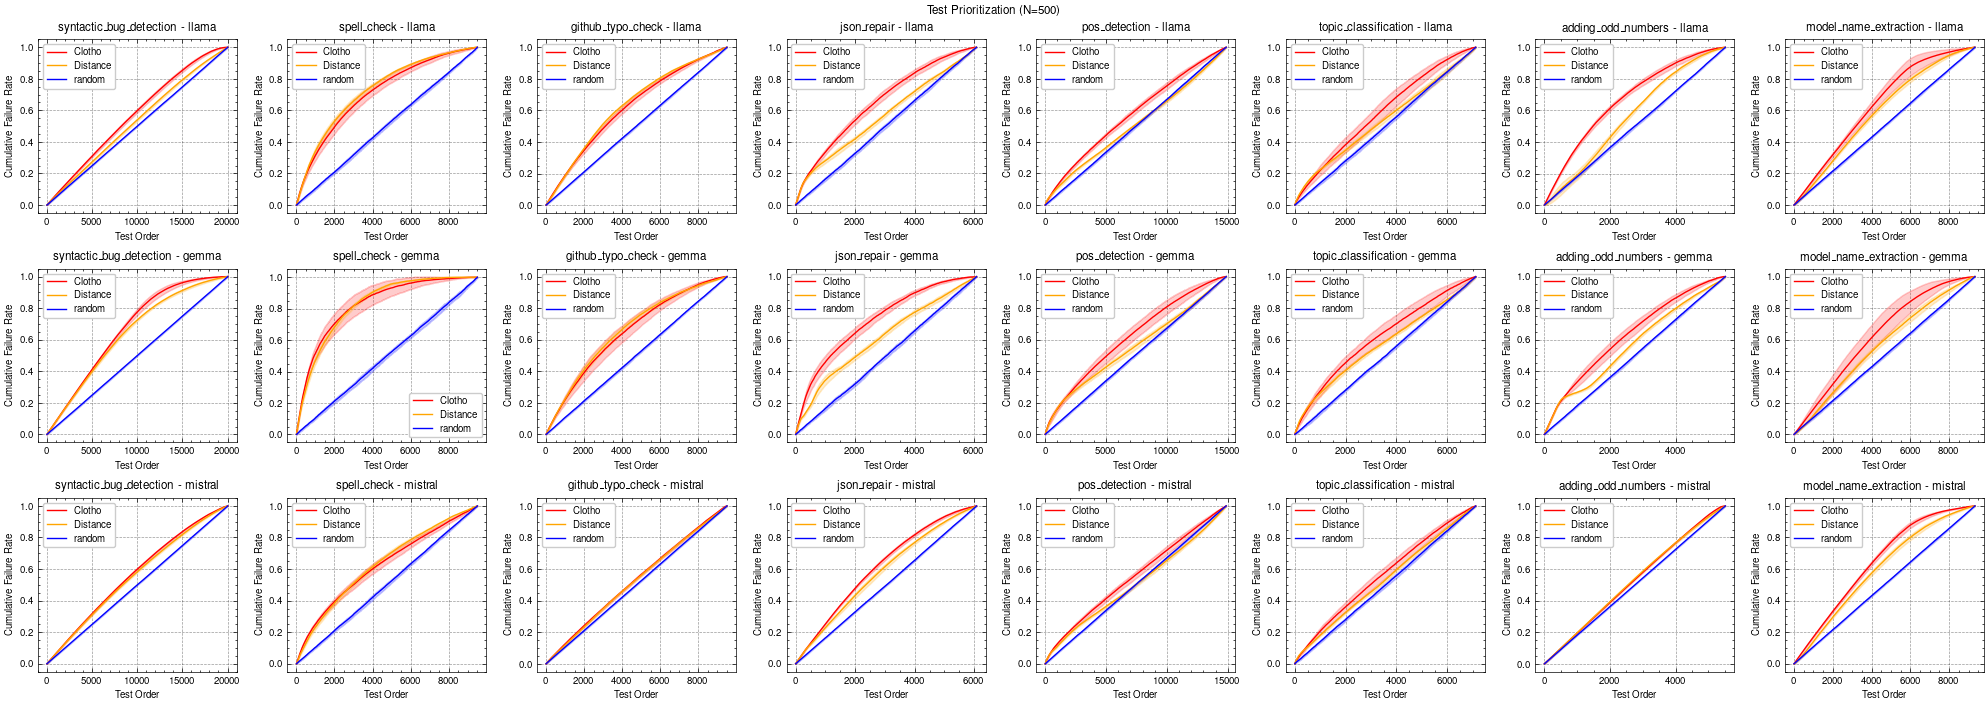

In [7]:
target_llms = ['llama', 'gemma', 'mistral']

all_dfs = []

fig, axes = plt.subplots(len(target_llms), len(target_testsuites), figsize=(2.5 * len(target_testsuites), 2.4 * len(target_llms)), sharex=False, sharey=False)

for i, target_llm in enumerate(target_llms):
    for j, task in enumerate(tqdm(target_testsuites, desc='Processing tasks')):
        prioritization_results = simulate_test_prioritization(task, target_method, num_reference, target_llm=target_llm)

        df = prioritization_results['APFD_majority'].copy()
        df['task'] = task
        df['target_llm'] = target_llm
        
        all_dfs.append(df)

        sns.lineplot(data=df[df['sort_method'] == 'Clotho'], x='index', y='failure_percent',
                    label='Clotho', color='red', errorbar='sd', ax=axes[i, j], err_kws={'alpha': 0.2})
        sns.lineplot(data=df[df['sort_method'] == 'Distance'], x='index', y='failure_percent',
                    label='Distance', color='orange', errorbar='sd', ax=axes[i, j], err_kws={'alpha': 0.2})
        sns.lineplot(data=df[df['sort_method'] == 'random'], x='index', y='failure_percent',
                    label='random', color='blue', errorbar='sd', ax=axes[i, j], err_kws={'alpha': 0.2})

        axes[i, j].set_xlabel('Test Order')
        axes[i, j].set_ylabel('Cumulative Failure Rate')
        axes[i, j].set_title(f'{task} - {target_llm}')
        axes[i, j].grid(alpha=0.4)
        axes[i, j].legend()

fig.suptitle(f"Test Prioritization (N={num_reference})")
fig.tight_layout()

In [ ]:
os.makedirs('./figures/rq2', exist_ok=True)
fig.savefig('./figures/rq2/APFDc_test_prioritization_all_tasks_and_models.png')
fig.savefig('./figures/rq2/APFDc_test_prioritization_all_tasks_and_models.pdf', dpi=300)

In [ ]:
result_df = pd.concat(all_dfs, ignore_index=True)

In [13]:
result_df[result_df.execution_index.isin([10, 50, 100, 150, 200, 250, 300])].groupby(['target_llm', 'task', 'execution_index', 'sort_method'])[['APFD', 'failure_cumulative', 'failure_percent']].mean()

APFD  \
target_llm task                 execution_index sort_method             
gemma      adding_odd_numbers   10              Clotho       0.631257   
                                                Distance     0.568317   
                                                random            NaN   
                                50              Clotho       0.631257   
                                                Distance     0.568317   
...                                                               ...   
mistral    topic_classification 250             Distance     0.530228   
                                                random            NaN   
                                300             Clotho       0.562068   
                                                Distance     0.530228   
                                                random            NaN   

                                                             failure_cumulative  \
target_llm task                 execution_index sort_method                       
gemma      adding_odd_numbers   10              Clotho                     11.0   
                                                Distance                   11.0   
                                                random                      4.6   
                                50              Clotho                     51.0   
                                                Distance                   51.0   
...                                                                         ...   
mistral    topic_classification 250             Distance                  116.1   
                                                random                     58.1   
                                300             Clotho                    121.9   
                                                Distance                  129.6   
                                                random                     70.5   

                                                             failure_percent  
target_llm task                 execution_index sort_method                   
gemma      adding_odd_numbers   10              Clotho              0.005087  
                                                Distance            0.005006  
                                                random              0.002083  
                                50              Clotho              0.023585  
                                                Distance            0.023211  
...                                                                      ...  
mistral    topic_classification 250             Distance            0.069606  
                                                random              0.034916  
                                300             Clotho              0.074980  
                                                Distance            0.077701  
                                                random              0.042368  

[504 rows x 3 columns]

In [39]:
cost_df = result_df[result_df.execution_index.isin([10, 50, 100, 150, 200, 250, 300, 500])].groupby(['target_llm', 'task', 'seed', 'execution_index', 'sort_method'])[['APFD', 'failure_cumulative']].mean().reset_index()
cost_df.loc[cost_df.sort_method == 'random', 'APFD'] = 0.5
cost_df_sum = cost_df[cost_df.execution_index.isin([100, 300, 500])].groupby(['target_llm', 'execution_index', 'sort_method'])[['APFD', 'failure_cumulative']].mean().reset_index().pivot(index=['target_llm', 'execution_index'], columns='sort_method')
cost_df_sum

APFD                  failure_cumulative  \
sort_method                   Clotho  Distance random             Clotho   
target_llm execution_index                                                 
gemma      100              0.670986  0.625390    0.5            78.0500   
           300              0.670986  0.625390    0.5           221.1500   
           500              0.670986  0.625390    0.5           343.0375   
llama      100              0.628720  0.584310    0.5            79.5250   
           300              0.628720  0.584310    0.5           217.8625   
           500              0.628720  0.584310    0.5           341.3750   
mistral    100              0.577598  0.557778    0.5            83.5750   
           300              0.577598  0.557778    0.5           237.4750   
           500              0.577598  0.557778    0.5           380.7000   

                                                
sort_method                 Distance    random  
target_llm execution_index                      
gemma      100               74.1500   29.5125  
           300              203.4000   88.3625  
           500              320.0750  146.5000  
llama      100               66.3500   35.3000  
           300              188.4250  106.6375  
           500              296.9875  178.2000  
mistral    100               78.6750   51.8500  
           300              221.9250  153.6375  
           500              354.4500  256.9625

In [43]:
cost_df_sum_group = cost_df_sum.groupby(['execution_index']).agg(['mean', 'std'])['failure_cumulative']
cost_df_sum_group

sort_method          Clotho               Distance               random  \
                       mean        std        mean        std      mean   
execution_index                                                           
100               80.383333   2.860762   73.058333   6.234598   38.8875   
300              225.495833  10.503677  204.583333  16.781320  116.2125   
500              355.037500  22.239917  323.837500  28.915429  193.8875   

sort_method                 
                       std  
execution_index             
100              11.592825  
300              33.674425  
500              56.877625

In [44]:
print('Clotho:', (cost_df_sum_group.loc[100, 'Clotho']['mean'] / 100), (cost_df_sum_group.loc[300, 'Clotho']['mean'] / 300), (cost_df_sum_group.loc[500, 'Clotho']['mean'] / 500))

print('Distance:', (cost_df_sum_group.loc[100, 'Distance']['mean'] / 100), (cost_df_sum_group.loc[300, 'Distance']['mean'] / 300), (cost_df_sum_group.loc[500, 'Distance']['mean'] / 500))

Clotho: 0.8038333333333334 0.7516527777777777 0.7100749999999999
Distance: 0.7305833333333334 0.6819444444444445 0.6476750000000001


In [19]:
df_fmt = cost_df_sum.copy()
df_fmt = df_fmt.round(2)
random_baseline = df_fmt.xs('random', axis=1, level=1)

percent_increase = {}
for method in df_fmt.columns.levels[1]:
    if method == 'random':
        continue
    percent_increase[method] = (
        (df_fmt.xs(method, axis=1, level=1) - random_baseline) / random_baseline * 100
    ).round(1)

for method, inc_df in percent_increase.items():
    for metric in inc_df.columns:
        df_fmt[(metric, method)] = (
            df_fmt[(metric, method)].astype(str) +
            " (+" + inc_df[metric].astype(str) + "\\%)"
        )

for metric in random_baseline.columns:
    df_fmt[(metric, 'random')] = df_fmt[(metric, 'random')].astype(str)

df_fmt = df_fmt.sort_index(axis=1, level=0)
df_fmt

APFD                         \
sort_method                         Clotho        Distance random   
target_llm execution_index                                          
gemma      100              0.67 (+34.0\%)  0.63 (+26.0\%)    0.5   
           200              0.67 (+34.0\%)  0.63 (+26.0\%)    0.5   
           300              0.67 (+34.0\%)  0.63 (+26.0\%)    0.5   
llama      100              0.63 (+26.0\%)  0.58 (+16.0\%)    0.5   
           200              0.63 (+26.0\%)  0.58 (+16.0\%)    0.5   
           300              0.63 (+26.0\%)  0.58 (+16.0\%)    0.5   
mistral    100              0.58 (+16.0\%)  0.56 (+12.0\%)    0.5   
           200              0.58 (+16.0\%)  0.56 (+12.0\%)    0.5   
           300              0.58 (+16.0\%)  0.56 (+12.0\%)    0.5   

                           failure_cumulative                             
sort_method                            Clotho           Distance  random  
target_llm execution_index                                                
gemma      100               78.05 (+164.5\%)   74.15 (+151.3\%)   29.51  
           200              151.01 (+154.1\%)  140.82 (+136.9\%)   59.44  
           300              221.15 (+150.3\%)   203.4 (+130.2\%)   88.36  
llama      100               79.53 (+125.3\%)    66.35 (+88.0\%)    35.3  
           200              151.49 (+112.7\%)   130.74 (+83.6\%)   71.21  
           300              217.86 (+104.3\%)   188.42 (+76.7\%)  106.64  
mistral    100                83.58 (+61.2\%)    78.68 (+51.7\%)   51.85  
           200               161.82 (+57.7\%)   151.76 (+47.9\%)  102.64  
           300               237.48 (+54.6\%)   221.92 (+44.4\%)  153.64

In [ ]:
result_df_fail_N = result_df[result_df.execution_index.isin([99, 299, 499])].copy()
agg_df = result_df_fail_N[result_df_fail_N.sort_method.isin(['Clotho', 'Distance', 'random']) & result_df_fail_N.target_llm.isin(['gemma', 'llama', 'mistral'])].groupby(['target_llm', 'task', 'sort_method', 'execution_index']).agg(
    mean=('failure_cumulative', 'mean'),
    std=('failure_cumulative', 'std')
)


pivot_df = (
    agg_df.reset_index()
          .pivot(
              index=['task', 'execution_index'],
              columns=['target_llm', 'sort_method'],
              values=['mean', 'std']
          )
)

agg_df['mean'] = agg_df['mean'].apply(lambda x: f'{x:.1f}')
# pivot_df = pivot_df.swaplevel(0, 2, axis=1).swaplevel(0, 1, axis=1).sort_index(axis=1, level=[0,1,2])

# display(pivot_df)
# print(pivot_df.to_latex(float_format="%.2f"))

pivot_df = (pivot_df
            .swaplevel(0, 2, axis=1)
            .swaplevel(0, 1, axis=1)
            .sort_index(axis=1, level=[0,1,2]))

# ---- 라텍스용 포맷팅 & \textbf 처리 ----
llms     = ['gemma', 'llama', 'mistral']
methods  = ['Clotho', 'Distance', 'random']

formatted = pivot_df.copy()

for llm in llms:
    mean_cols = [(llm, m, 'mean') for m in methods if (llm, m, 'mean') in formatted.columns]
    if not mean_cols:
        continue
    means_sub = pivot_df.loc[:, mean_cols].astype(float)
    row_max   = means_sub.max(axis=1)

    for m in methods:
        col = (llm, m, 'mean')
        if col not in formatted.columns:
            continue
        vals = means_sub[col]
        s = vals.map(lambda v: f"{v:.1f}")
        bold_mask = np.isclose(vals, row_max, rtol=0, atol=1e-12)
        s.loc[bold_mask] = s.loc[bold_mask].map(lambda v: f"\\textbf{{{v}}}")
        formatted[col] = s

    for m in methods:
        col = (llm, m, 'std')
        if col in formatted.columns:
            formatted[col] = pivot_df[col].astype(float).map(lambda v: f"{v:.2f}")

print(formatted.to_latex(escape=False))

\begin{tabular}{llllllllllllllllllll}
\toprule
 & target_llm & \multicolumn{6}{r}{gemma} & \multicolumn{6}{r}{llama} & \multicolumn{6}{r}{mistral} \\
 & sort_method & \multicolumn{2}{r}{Clotho} & \multicolumn{2}{r}{Distance} & \multicolumn{2}{r}{random} & \multicolumn{2}{r}{Clotho} & \multicolumn{2}{r}{Distance} & \multicolumn{2}{r}{random} & \multicolumn{2}{r}{Clotho} & \multicolumn{2}{r}{Distance} & \multicolumn{2}{r}{random} \\
 &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\
task & execution_index &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{adding_odd_numbers} & 99 & \textbf{100.0} & 0.00 & \textbf{100.0} & 0.00 & 40.7 & 4.06 & \textbf{95.9} & 7.22 & 29.0 & 18.62 & 38.1 & 3.11 & \textbf{99.9} & 0.32 & 96.4 & 4.43 & 91.4 & 1.90 \\
 & 299 & 299.5 & 0.71 & \textbf{300.0} & 0.00 & 124.7 & 9.08 & \textbf{284.0} & 11.98 & 123.9 & 59.64 & 117.2 & 5.53 & \textbf{299.7} & 0.95

In [21]:
# Aggregated across tasks

result_df_fail_N = result_df[result_df.execution_index.isin([99, 299, 499])].copy()

agg_df = result_df_fail_N[result_df_fail_N.sort_method.isin(['Clotho', 'Distance', 'random'])].groupby(['target_llm', 'sort_method', 'execution_index']).agg(
    mean=('failure_cumulative', 'mean'),
    std=('failure_cumulative', 'std')
).reset_index()

agg_df['failure_cumulative (mean)'] = agg_df.apply(
    lambda r: f"{r['mean']:.3f} ± {r['std']:.2f}", axis=1
)

table = agg_df.pivot(index=['execution_index'], columns=('target_llm', 'sort_method'), values='failure_cumulative (mean)')
table

target_llm                  gemma                                     \
sort_method                Clotho          Distance           random   
execution_index                                                        
99                 77.250 ± 20.38    73.537 ± 22.12   29.300 ± 15.38   
299               220.488 ± 62.18   202.900 ± 71.28   88.112 ± 44.36   
499              342.500 ± 101.63  319.550 ± 119.34  146.275 ± 72.05   

target_llm                 llama                                    \
sort_method               Clotho         Distance           random   
execution_index                                                      
99                78.750 ± 16.39   65.700 ± 21.12   34.950 ± 14.90   
299              217.188 ± 55.27  187.812 ± 51.50  106.250 ± 45.55   
499              340.712 ± 95.52  296.363 ± 81.15  177.762 ± 75.13   

target_llm               mistral                                      
sort_method               Clotho          Distance            random  
execution_index                                                       
99                82.775 ± 16.42    77.875 ± 20.02    51.375 ± 24.01  
299              236.775 ± 56.36   221.175 ± 61.94   153.188 ± 71.71  
499              380.075 ± 99.82  353.875 ± 104.64  256.462 ± 118.63

In [ ]:
table.to_latex('./tables/rq2_failure_at_n_agg.tex')